In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
if os.name == 'nt':
    import sys
    sys.path.append('C:\\Users\\manojselvam\\Anaconda3\\envs\\py3\\lib\\site-packages\\')

    
import cv2
import glob
import pickle
import os
import matplotlib.image as mpimg
from skimage import data, filter, io
import skimage 
import scipy
from collections import deque
import time
from tqdm import tqdm
from moviepy.editor import VideoFileClip



/Users/manojselvam/anaconda/envs/py3/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [2]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
# from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage.measurements import label

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets

In [4]:
%matplotlib inline

In [5]:
# Load a pickle file
def load_pickle(file_path):
    with open(file_path, mode='rb') as f:
        file_data = pickle.load(f)
        return file_data;


# Create a pickle
def create_pickle(file_path, data):
    pickle.dump(data, open(file_path, "wb"))
    print("Data saved in", file_path)

In [6]:
def display_images(rows,cols,images,labels, random=False,colour_converter=None):
    gs1 = gridspec.GridSpec(rows,cols)
    gs1.update(wspace=0.01, hspace=0.02)
    plt.figure(figsize=(12,8))
    for i in range(rows * cols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        idx = i
        if random:
            idx = np.random.choice(len(images))
            
        plt.text(2,5,
                 str(labels[idx]),
                 color='k',
                 backgroundcolor='c')
        if colour_converter == None:
            plt.imshow(images[idx])
        else:
            plt.imshow(cv2.cvtColor(images[idx],colour_converter))
        plt.axis('off')

    plt.show()

In [7]:
def load_and_show_img(path):
    img  = cv2.imread(path)
    plt.imshow(img)
    

In [8]:
# load the cars and non_cars dataset
def load_dataset():
    cars = []
    non_cars = []
    
    non_car_files = glob.glob('non-vehicles/*/*.png')
    car_files = glob.glob('vehicles/*/*.png')
    
    for file in car_files:
        cars.append(mpimg.imread(file))
    for file in non_car_files:
        non_cars.append(mpimg.imread(file))
        
    return (np.asarray(cars),np.asarray(non_cars))
        

In [9]:
cars, non_cars = load_dataset()

In [10]:
print("Number of cars     :", len(cars))
print("Number of non cars :", len(non_cars))

Number of cars     : 8792
Number of non cars : 8968


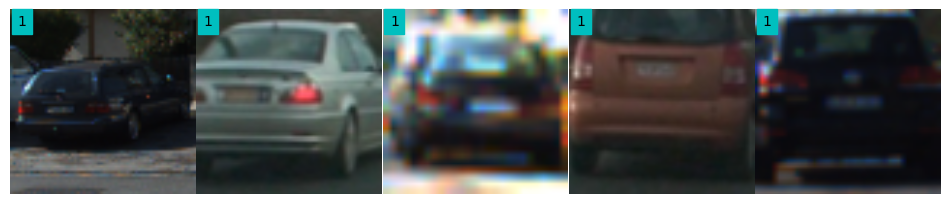

In [11]:
display_images(1,5,cars,np.ones(len(cars),np.int16),random=True,colour_converter=None)

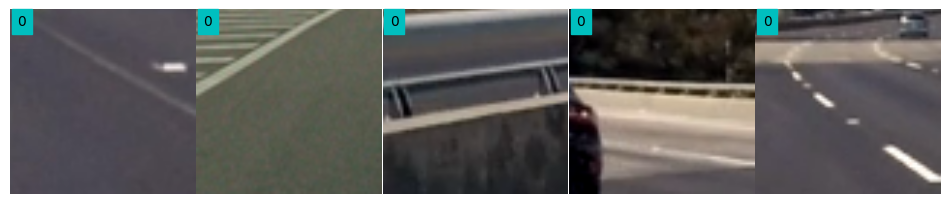

In [12]:
display_images(1,5,non_cars,np.zeros(len(non_cars),np.int16),random=True,colour_converter=None)

In [12]:
# extract histogram features from a three channel image 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = c1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return c1_hist, c2_hist, c3_hist, bin_centers, hist_features



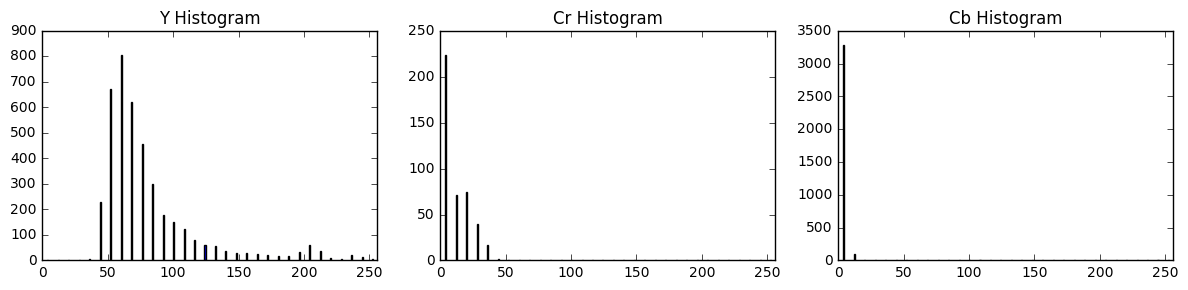

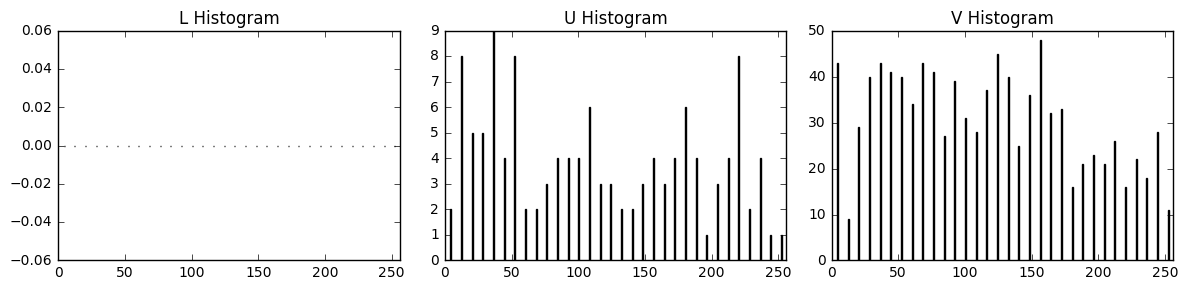

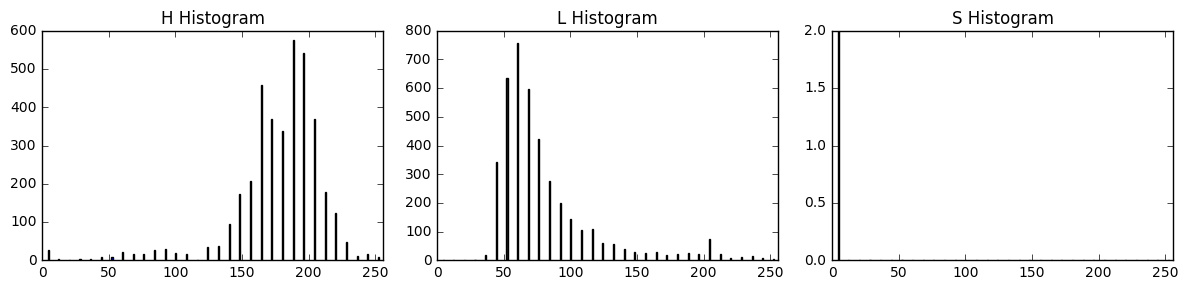

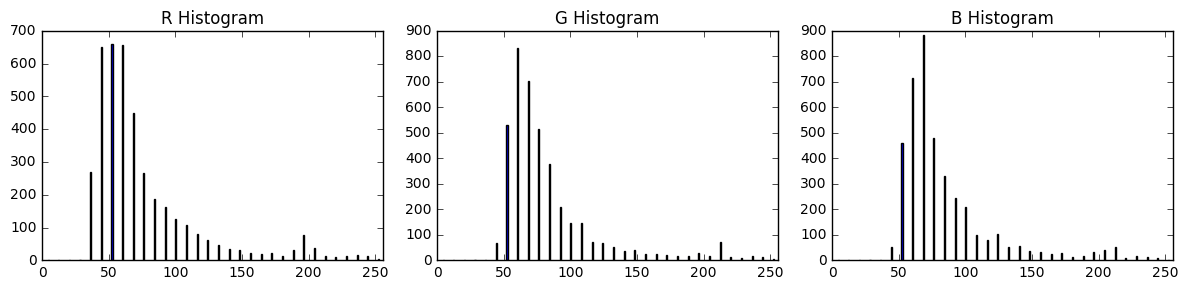

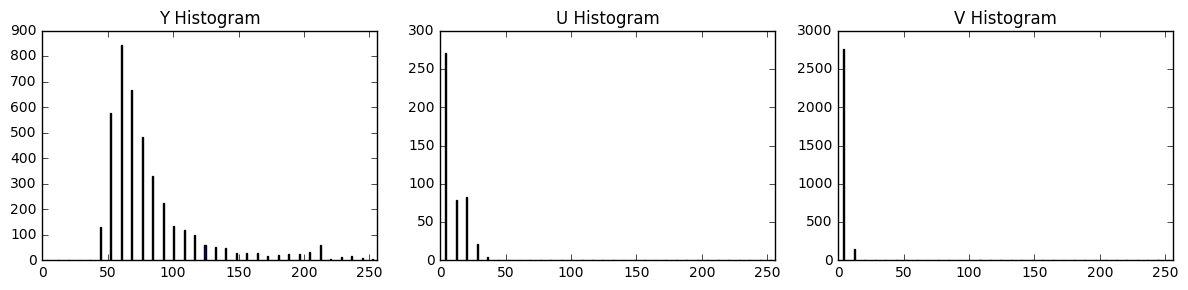

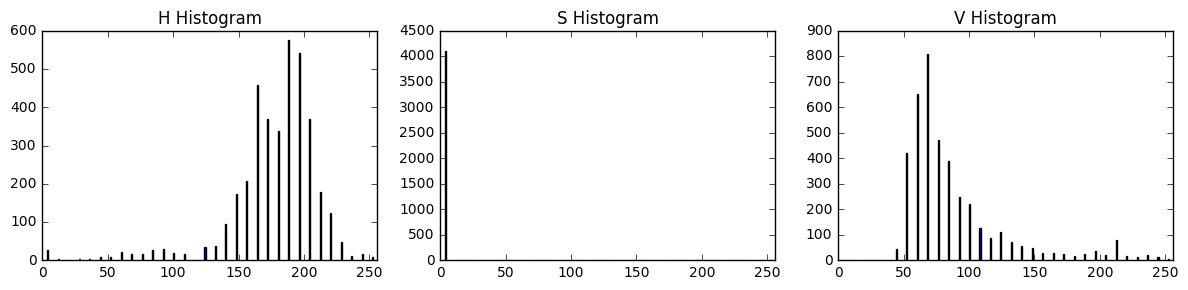

In [13]:
# exploring histogram different colour spaces  
image = cars[1000] * 255

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

colour_spaces= {'H_S_V':hsv,
                'R_G_B':image,
                'L_U_V':luv,
                'H_L_S':hls,
                'Y_U_V':yuv,
                'Y_Cr_Cb':YCrCb,
               }

                   
for key in colour_spaces.keys():    
    rh, gh, bh, bincen, feature_vec = color_hist(colour_spaces[key], nbins=32, bins_range=(0, 256))
    channel_name = key.split('_')
    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title(channel_name[0] + ' Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title(channel_name[1] + ' Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title(channel_name[2] + ' Histogram')
        fig.tight_layout()

In [14]:
# convert colour spaces util
def cvt_image_colour_space(img,color_space='RGB'):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)            
    
    return feature_image


In [15]:
# resize the image
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    feature_image = cvt_image_colour_space(img,color_space=color_space)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [16]:
spatial_features = bin_spatial(image)
print(len(spatial_features),spatial_features)

3072 [ 40.75  70.25  70.   ...,  74.25  81.75  76.  ]


In [17]:
# hog feature extraction
def get_hog_features(img, orient=9, pix_per_cell=9, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [18]:
feature = get_hog_features(yuv[:,:,2],vis=False)

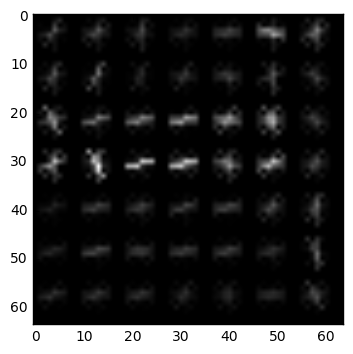

In [19]:
feature, hog_img = get_hog_features(YCrCb[:,:,2],vis=True)
plt.imshow(hog_img,cmap='gray')

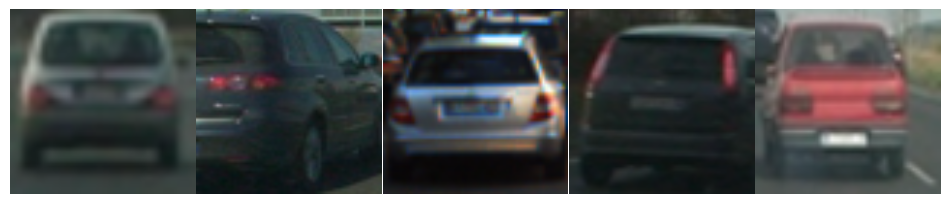

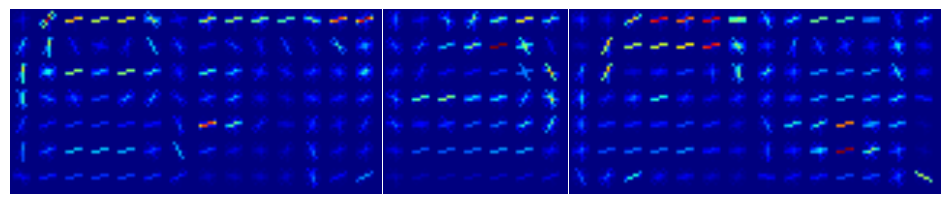

In [21]:
hogs_img   = []
hogs_feat_img   = []
hogs_label = []

for i in range(0,5):
    i = cars[np.random.randint(0,5000)]
    hogs_img.append(i)
    hogs_label.append("")
display_images(1,5,hogs_img,hogs_label)

for i in range(0,5):
    i = cvt_image_colour_space(hogs_img[i],"YUV")
    feature, hog_img = get_hog_features(i[:,:,0],vis=True)

    hogs_feat_img.append(hog_img)
    hogs_label.append("")
        
display_images(1,5,hogs_feat_img,hogs_label)

In [22]:
# get features from an image 
def get_features(img):
    
    features  = []
    
    #HOG
    yuv = cvt_image_colour_space(img,'YUV')
    for channel in range(3):
        features.append(get_hog_features(yuv[:,:,channel],vis=False,orient=10,pix_per_cell=8))

    # colour hist    
    c1_hist, c2_hist, c2_hist, bincen, feature_vec = color_hist(img, nbins=32, bins_range=(0, 256))
    features.append(feature_vec)
    
    # spatial binning 
    spatial_features = bin_spatial(image)
    features.append(spatial_features)
    
    return np.concatenate(features)
    

In [23]:
img_features = get_features(image)
img_features.shape

(9048,)

In [24]:
def extract_all_features(cars,non_cars):
    car_features = []
    non_car_features = []
    
    print("Cars")
    for car in tqdm(cars):
        feature = get_features(car)
        car_features.append(feature)
    
    print("Non Cars")
    for non_car in tqdm(non_cars):
        feature = get_features(non_car)
        non_car_features.append(feature)
    
    return car_features,non_car_features
        
    

In [25]:
%time car_features,non_car_features = extract_all_features(cars,non_cars)


  0%|          | 15/8792 [00:00<00:59, 147.01it/s]

Cars


  0%|          | 17/8968 [00:00<00:54, 163.20it/s]

Non Cars


100%|██████████| 8968/8968 [00:54<00:00, 165.07it/s]

CPU times: user 1min 45s, sys: 2.44 s, total: 1min 47s
Wall time: 1min 48s


In [26]:
# scale features
X = np.vstack((car_features, non_car_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)),np.zeros(len(non_car_features))))

# normalise features 
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

In [27]:
# train classifier
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=np.random.randint(0,50))
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('Accuracy : ', accuracy)


Accuracy :  0.982


####  search for cars 

In [28]:
test_images = glob.glob('./test_images/*.jpg')

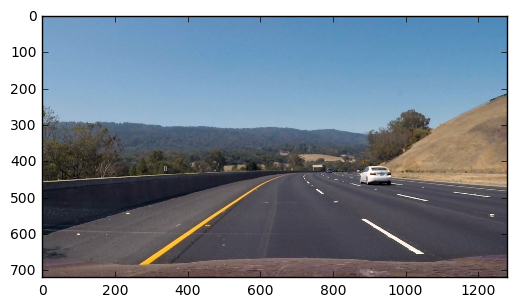

In [29]:
test_image = mpimg.imread(test_images[4])
plt.imshow(test_image)

In [30]:
def get_rnd_color():
     return (255,np.random.randint(0,255),np.random.randint(0,255))

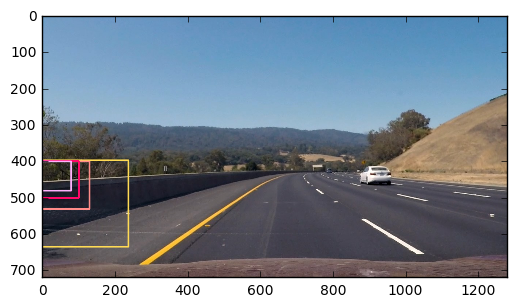

In [31]:
scales =  [.8,.6,.5,.3]      # scale the whole image down by this factor 
y_start = [.53,.53,.53,.53]  # the starting position of the window. 

scales = np.array([.27, .49, .63, .8])
y_start = np.array([.56, .56, .56, .56])
h,w,d = test_image.shape
windows = []

for scale,y_scale in zip(scales,y_start):
    s = np.copy(test_image)
    scaled_image = resize(s,(int(h * scale),int(w * scale)))
    sh,sw,sd = scaled_image.shape
    rect_top = int(sh * y_scale)
    upscaled_rect_top = int(rect_top // scale)
    
    window = ((0, rect_top), (64, rect_top + 64))
    up_scaled_window = ((0, upscaled_rect_top), (int(64/scale), int(upscaled_rect_top + 64/scale)))
    windows.append(up_scaled_window)



# print(windows)

s = np.copy(test_image)
for window in windows:
    color = (255,np.random.randint(0,255),np.random.randint(0,255))
    cv2.rectangle(s, window[0], window[1], color, 4)

plt.imshow(s)


In [51]:
def find_cars(image,scale,y_scale,window_width=64,outline_windows=False):
    
    positive_windows = np.empty([0, 4], dtype=np.int)
    scanned_windows = np.empty([0, 4], dtype=np.int)
    h,w,d = image.shape
    img = np.copy(image)
    scaled_image = resize(img,(int(h * scale),int(w * scale))).astype(np.float32)
    sh,sw,sd = scaled_image.shape
    
    rect_top_y = int(sh * y_scale)
    
    stride = window_width // 3
    start = 0
    stop = sw - window_width
    smaple_cout = (sw + stride) // stride
    x = np.linspace(start,stop,num=smaple_cout,dtype=np.int16)
    for x in x:
        # move the widow from left to right.
        window = ((x, rect_top_y), (x + window_width, rect_top_y + window_width))
#         cv2.rectangle(scaled_image, window[0], window[1], (0, 0, 255), 1)
        window_img = scaled_image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        features = get_features(window_img)
        features = X_scaler.transform(np.array(features).reshape(1, -1))
        
        if svc.predict(features)[0] == 1:
#             cv2.rectangle(scaled_image, window[0], window[1], (0, 0, 255), 2)
            positive_windows = np.append(positive_windows,[[window[0][0],window[0][1],window[1][0],window[1][1]]],axis=0)
    
        scanned_windows = np.append(scanned_windows,[[window[0][0],window[0][1],window[1][0],window[1][1]]],axis=0)
        
    positive_windows = positive_windows / scale
    scanned_windows = scanned_windows / scale
    
    return positive_windows.astype(np.int),scanned_windows.astype(np.int)
    

In [60]:
def add_heat(heatmap, coordinates):
        """
        Add heat to the heatmap.
        
        """
        for coordinate in coordinates:
            #(x1, y1, x2, y2)
            x1 = coordinate[0]
            y1 = coordinate[1]
            x2 = coordinate[2]
            y2 = coordinate[3]
            
           
            heatmap[y1:y2, x1:x2] += 1

        return heatmap
    
def merge_detections(detections, image_shape, threshold):
        """
        merge detections by building a heat map.
        filter the heat map based on threshold
        return detections and heatmap
        """
        
#         print("merge detection",len(detections))

        # create heatmap
        heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)
        
        # update heatmap
        heatmap = add_heat(heatmap, detections)
        
        # filter heatmap
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        vehicles = np.empty([0, 4], dtype=np.int64)
        
        for vehicle in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == vehicle).nonzero()
            
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            bbox = [[np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)]]
            
            if (bbox[0][2] - bbox[0][0]) > 22:
                vehicles = np.append(vehicles,bbox,axis=0)
            
        # Return the image
        return (vehicles, heatmap)

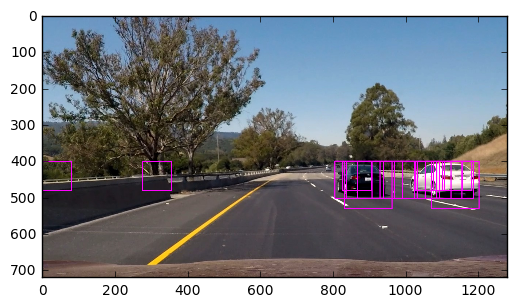

In [35]:
test_image = mpimg.imread(test_images[7])
detections = np.empty([0, 4], dtype=np.int64)
img_cp =np.copy(test_image)
img_scanned =np.copy(test_image)

for index in range(len(scales)): 
    detected_windows,scanned_windows = find_cars(test_image,scales[index],y_start[index])
    detections = np.append(detections, detected_windows, axis=0)
    color =  get_rnd_color()
    for window in scanned_windows:
        cv2.rectangle(img_scanned, (window[0], window[1]),(window[2], window[3]), color, 2)


for window in detections:
    cv2.rectangle(img_cp, (window[0], window[1]),(window[2], window[3]), (255, 0, 255), 2)
    
plt.imshow(img_cp)



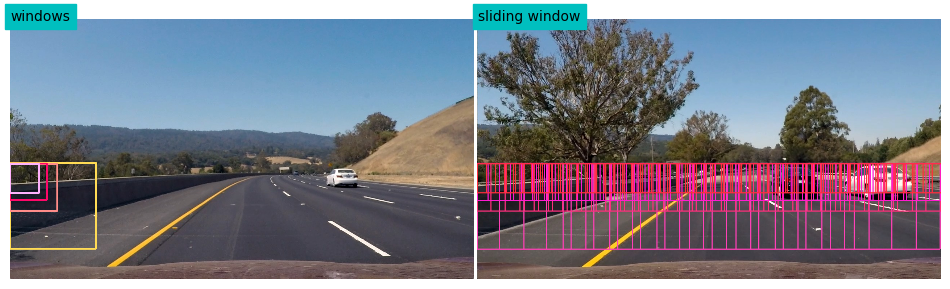

In [36]:
display_images(1,2,[s,img_scanned],["windows","sliding window"])

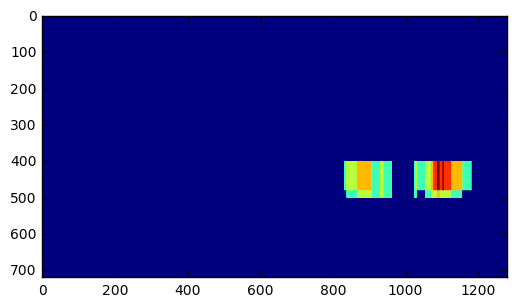

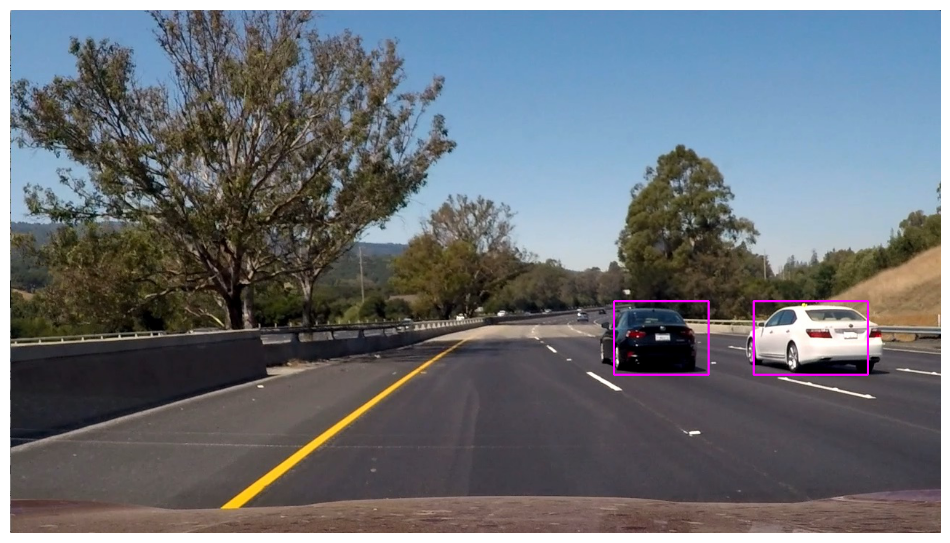

In [37]:
img_cp =np.copy(test_image)

final_detections, heatmap = merge_detections(detections, test_image.shape, threshold=3)
for window in final_detections:
    cv2.rectangle(img_cp, (window[0], window[1]),(window[2], window[3]), (255, 0, 255), 2)
    
plt.imshow(heatmap)
display_images(1,1,[img_cp],[""])

In [68]:
def pipeline(image,debug=False):
    detections = np.empty([0, 4], dtype=np.int64)
    all_detections_img =np.copy(image)
    for index in range(len(scales)): 
        detected_windows,_ = find_cars(image,scales[index],y_start[index])
        detections = np.append(detections, detected_windows, axis=0)
        
#         for window in _:
#             cv2.rectangle(all_detections_img, (window[0], window[1]),(window[2], window[3]), (0, 0, 255), 3)
    

    for window in detections:
        cv2.rectangle(all_detections_img, (window[0], window[1]),(window[2], window[3]), (0, 0, 255), 3)
    
    
    
    merged_detections_img =np.copy(image)
    
    final_detections, heatmap = merge_detections(detections, image.shape, threshold=1)
    
    # append to the global detections cache.
    global detection_history
    if len(detections) != 0 or len(detection_history) == 0:
        detection_history.append(detections)

#     print(final_detections)
#     print(np.concatenate(np.array(detection_history)))
#     print("detection_history",len(detection_history), len(final_detections), len(np.concatenate(np.array(detection_history))))
   
    # merge detections over different frames
    global_detections, global_heatmap = merge_detections(
            np.concatenate(np.array(detection_history)),
            image.shape,
            threshold=min(int(len(detection_history) + 1), 20)
    )
    
#     print("max local, global", np.max(heatmap),np.max(global_heatmap))
#     global_detections,global_heatmap = final_detections,heatmap
    
    
    for window in global_detections:
        cv2.rectangle(merged_detections_img, (window[0], window[1]),(window[2], window[3]), (255, 0, 0), 4)
    h_map =  cv2.merge((global_heatmap,global_heatmap,global_heatmap))
    
    if debug:
        return [image,all_detections_img,merged_detections_img,global_heatmap]
    else:
#         display_images(1,4,[all_detections_img,merged_detections_img,heatmap,global_heatmap],["all","merged","local","global"])
#         return merged_detections_img
        return np.hstack((all_detections_img,merged_detections_img))

In [39]:
# detection cache
detection_history = None

In [40]:
def clear_cache():
    global detection_history
    detection_history = deque(maxlen=20)

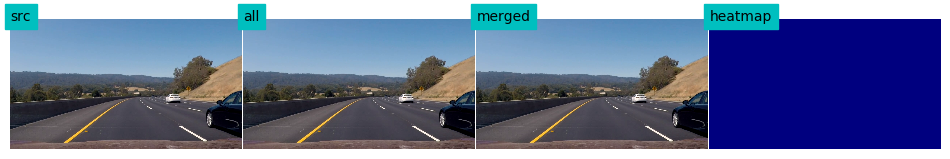

In [62]:
clear_cache();
test_image = mpimg.imread(test_images[2])
video = VideoFileClip("project_video.mp4",audio=False)
test_image = video.get_frame(t=28)

result = pipeline(test_image,debug=True)
#     plt.imshow(result[2])
display_images(1,4,result,["src","all","merged","heatmap"])

In [75]:
test_images[0].split('/')[2]

'straight_lines1.jpg'

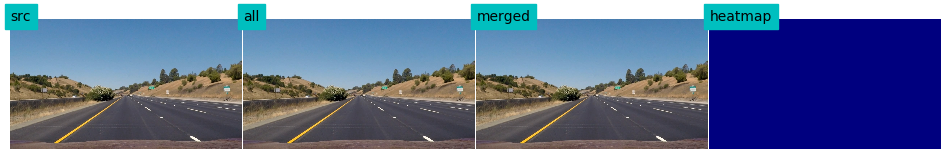

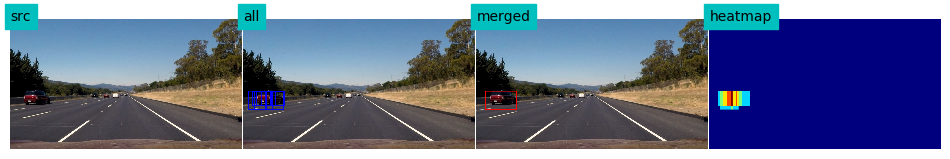

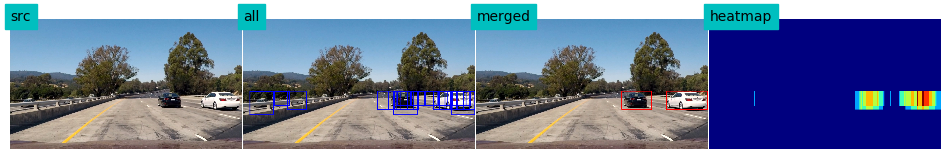

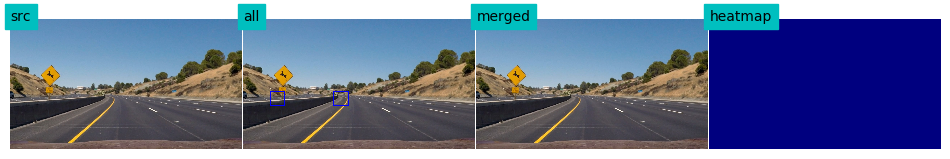

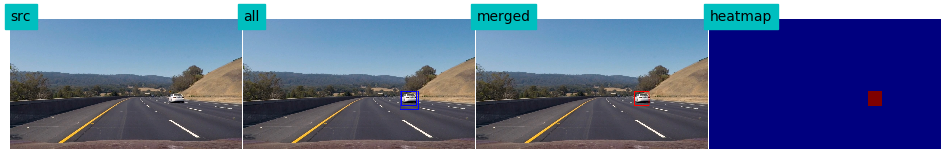

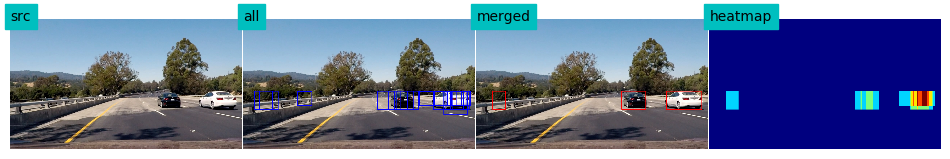

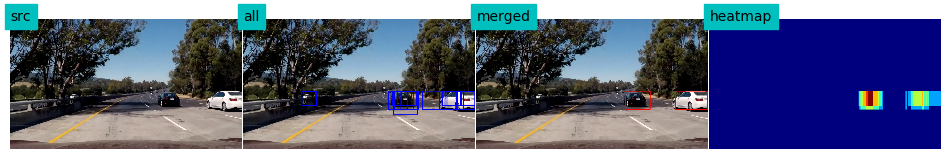

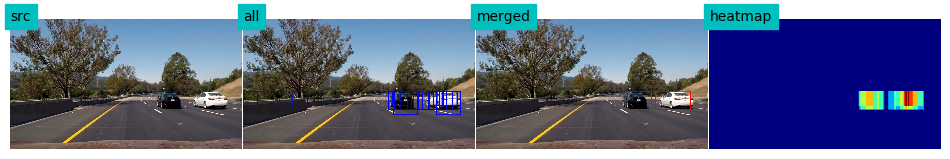

In [77]:
for file in test_images:
    clear_cache();
    test_image = mpimg.imread(file)
    result = pipeline(test_image,debug=True)
#     plt.imshow(result[2])
    display_images(1,4,result,["src","all","merged","heatmap"])
    mpimg.imsave("./output_images_car_detection/" + file.split('/')[2] , result[2])
    

In [71]:
from moviepy.editor import VideoFileClip
left = None
right = None
clear_cache();
video_output_name = 'car_detection_annotated_7.mp4'
video = VideoFileClip("project_video.mp4",audio=False)

def video_pipeline(img):
    return pipeline(img,debug=False)

video_output = video.fl_image(video_pipeline)
%time video_output.write_videofile(video_output_name, audio=False)

[MoviePy] >>>> Building video car_detection_annotated_7.mp4
[MoviePy] Writing video car_detection_annotated_7.mp4





  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:01<00:02,  1.13s/it]


 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: car_detection_annotated_7.mp4 

CPU times: user 3.06 s, sys: 290 ms, total: 3.35 s
Wall time: 3.53 s


In [1]:
# video = VideoFileClip("project_video_1.mp4",audio=False)
# for i in range(23,25):
#     clear_cache();
#     test_image = video.get_frame(t=i)
#     result = pipeline(test_image,debug=False)
# #     plt.imshow(result[2])
#     display_images(1,1,[result],["all"])